# Using Self-supervised pretraining to complete an online data science challenge

Plan here is to try solving this problem by self-supervised pretraining, using SWAV or VICReg and Resnet-34. The dataset consists of images of two types for each sample: RGB and RGNIR (RG-Near-Infra-Red). Since we have two images per sample in the training set, we assume the image's copy already exists and that the different camera contributes a "natural augmentation" of the same image. The other augmentations in SWAV or VICReg are kind of a bonus but it would better to ablate them.

![SwAV](images/swav.png)

In [1]:
??SwAVModel

Object `SwAVModel` not found.


**Unsupervised Learning of Visual Features
by Contrasting Cluster Assignments**

https://arxiv.org/pdf/2006.09882.pdf

**Absract**: Unsupervised image representations have significantly reduced the gap with supervised
pretraining, notably with the recent achievements of contrastive learning
methods. These contrastive methods typically work online and rely on a large number
of explicit pairwise feature comparisons, which is computationally challenging.
In this paper, we propose an online algorithm, SwAV, that takes advantage of contrastive
methods without requiring to compute pairwise comparisons. Specifically,
our method simultaneously clusters the data while enforcing consistency between
cluster assignments produced for different augmentations (or “views”) of the same
image, instead of comparing features directly as in contrastive learning. Simply put,
we use a “swapped” prediction mechanism where we predict the code of a view
from the representation of another view. Our method can be trained with large and
small batches and can scale to unlimited amounts of data. Compared to previous
contrastive methods, our method is more memory efficient since it does not require
a large memory bank or a special momentum network. In addition, we also propose
a new data augmentation strategy, multi-crop, that uses a mix of views with
different resolutions in place of two full-resolution views, without increasing the
memory or compute requirements. We validate our findings by achieving 75:3%
top-1 accuracy on ImageNet with ResNet-50, as well as surpassing supervised
pretraining on all the considered transfer tasks.

In [2]:
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files

In [3]:
from fastai.vision.all import *

In [4]:
path = Path("/home/mu/.fastai/data/rice-disease-classification/")
files = get_image_files(path/"images")
files[0]

Path('/home/mu/.fastai/data/rice-disease-classification/images/id_dvirq2t8zp_rgn.jpg')

In [5]:
path.ls()

(#6) [Path('/home/mu/.fastai/data/rice-disease-classification/SampleSubmission.csv'),Path('/home/mu/.fastai/data/rice-disease-classification/images'),Path('/home/mu/.fastai/data/rice-disease-classification/Train.csv'),Path('/home/mu/.fastai/data/rice-disease-classification/Images.zip'),Path('/home/mu/.fastai/data/rice-disease-classification/events.out.tfevents.1657285352.exobrain.2031815.0'),Path('/home/mu/.fastai/data/rice-disease-classification/Test.csv')]

In [6]:
import PIL

In [7]:
img = PIL.Image.open(files[0])

In [8]:
img

In [9]:
%timeit?

Docstring:
Time execution of a Python statement or expression

Usage, in line mode:
  %timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] statement
or in cell mode:
  %%timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] setup_code
  code
  code...

Time execution of a Python statement or expression using the timeit
module.  This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, the statement in the first line is used as setup code
  (executed but not timed) and the body of the cell is timed.  The cell
  body has access to any variables created in the setup code.

Options:
-n<N>: execute the given statement <N> times in a loop. If <N> is not
provided, <N> is determined so as to get sufficient accuracy.

-r<R>: number of repeats <R>, each consisting of <N> loops, and take the
best result.
Default: 7

-t: use time.time to measure the time, which is the default on Unix.
This f

In [10]:
# %%timeit
# for i in range(100000000):
#     assert math.floor(0.1 * 0.00000000004) <= 4e-12

In [11]:
files[1]

Path('/home/mu/.fastai/data/rice-disease-classification/images/id_w4li9hey14.jpg')

In [12]:
files[1].name

'id_w4li9hey14.jpg'

In [13]:
type(files[1])

pathlib.PosixPath

In [14]:
img = PIL.Image.open(files[1])

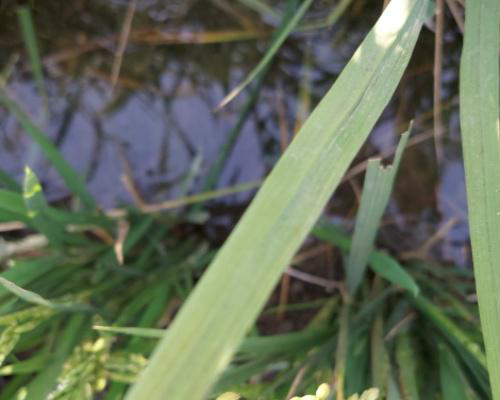

In [15]:
img

We need to write a function that finds the two pictures matching a particular image ID.  So we need to read the csv.

In [16]:
train_df = pd.read_csv(path/"Train.csv")

In [17]:
train_df.head()

Image_id  Label
0      id_004wknd7qd.jpg  blast
1  id_004wknd7qd_rgn.jpg  blast
2      id_005sitfgr2.jpg  brown
3  id_005sitfgr2_rgn.jpg  brown
4      id_00stp9t6m6.jpg  blast

In [18]:
test_df = pd.read_csv(path/"Test.csv")
test_df.head()

Image_id
0      id_00vl5wvxq3.jpg
1  id_00vl5wvxq3_rgn.jpg
2      id_01hu05mtch.jpg
3  id_01hu05mtch_rgn.jpg
4      id_030ln10ewn.jpg

In [19]:
def open_image(fname, size=224):
    "standard vision preprocessing: resize, convert image to tensor, normalize pixels, reorder channels"
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [20]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [21]:
def find_matching_file(fname):
    """Find files matching the pattern: 'id_004wknd7qd_rgn.jpg' and get their name without the _rgn."""
    return "_".join(re.match(r'^(.*)_(.*)_rgn.jpg$', fname.name).groups())+".jpg"

In [22]:
# group the files to make the process of matching RGB images with their RGN counterparts a little easier
rgn = [f for f in files if "_rgn" in f.name]
train_fnames = [f for f in rgn if f.name in list(train_df.Image_id.values)]
valid_fnames = [f for f in rgn if f.name in list(test_df.Image_id.values)]

In [23]:
len(train_fnames), len(valid_fnames)

(2670, 1145)

In [24]:
files[0].name

'id_dvirq2t8zp_rgn.jpg'

In [25]:
train_df.iloc[1].Image_id

'id_004wknd7qd_rgn.jpg'

In [26]:
list(map(lambda x: (find_matching_file(x), x.name), train_fnames[:10]))

[('id_dvirq2t8zp.jpg', 'id_dvirq2t8zp_rgn.jpg'),
 ('id_fyx4sjjmqo.jpg', 'id_fyx4sjjmqo_rgn.jpg'),
 ('id_6brz9uie9y.jpg', 'id_6brz9uie9y_rgn.jpg'),
 ('id_1cq9rbrysn.jpg', 'id_1cq9rbrysn_rgn.jpg'),
 ('id_vbmasab4sj.jpg', 'id_vbmasab4sj_rgn.jpg'),
 ('id_wpj3o0ib5o.jpg', 'id_wpj3o0ib5o_rgn.jpg'),
 ('id_ab6vj4fvrn.jpg', 'id_ab6vj4fvrn_rgn.jpg'),
 ('id_7ulmi3qvmo.jpg', 'id_7ulmi3qvmo_rgn.jpg'),
 ('id_q0adhxcxud.jpg', 'id_q0adhxcxud_rgn.jpg'),
 ('id_6gfouzum5z.jpg', 'id_6gfouzum5z_rgn.jpg')]

In [27]:
find_matching_file(train_fnames[0])

'id_dvirq2t8zp.jpg'

In [28]:
image_path = path/"images"

In [29]:
# size=224
# size=64
size=128

In [30]:
class SelfSupervisedTransform(Transform):
    def __init__(self, files):
        self.files = files
        
    def encodes(self, i):
        """Structure a RGB image next to a RGNIR image"""
        rgnir = self.files[i]
        rgb = self._draw(rgnir)
        img1,img2 = open_image(image_path/rgb, size=size),open_image(image_path/rgnir, size=size)
        return (TensorImage(img1), TensorImage(img2))
    
    def _draw(self, f):
        return find_matching_file(f)

In [31]:
train_ds = SelfSupervisedTransform(train_fnames)
valid_ds = SelfSupervisedTransform(valid_fnames)

In [32]:
train_tl= TfmdLists(range(len(train_fnames)), train_ds)
valid_tl= TfmdLists(range(len(valid_fnames)), valid_ds)

In [33]:
from fastai.data.core import DataLoaders
bs=32
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=bs,
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

In [34]:
dls.cuda()

In [35]:
# dls.one_batch()

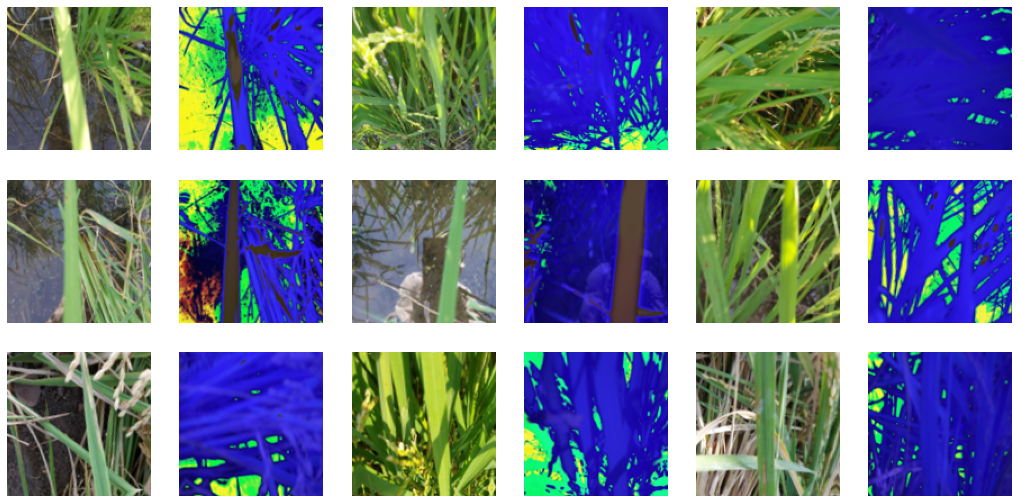

In [36]:
dls.show_batch()

In [37]:
class SelfSupervisedImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1, img2 = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title="RGB | RGNIR", ctx=ctx, **kwargs)

In [38]:
find_matching_file(files[0])

'id_dvirq2t8zp.jpg'

In [39]:
rgnir = PILImage.create(files[0])
rgb = PILImage.create(image_path/find_matching_file(files[0]))
ssi = SelfSupervisedImage(rgb, rgnir)

In [40]:
??explode_types

Signature: explode_types(o)
Source:   
def explode_types(o):
    "Return the type of `o`, potentially in nested dictionaries for thing that are listy"
    if not is_listy(o): return type(o)
    return {type(o): [explode_types(o_) for o_ in o]}
File:      ~/miniconda3/envs/rave/lib/python3.9/site-packages/fastcore/dispatch.py
Type:      function


In [41]:
b = dls.one_batch()
explode_types(b)

{tuple: [fastai.torch_core.TensorImage, fastai.torch_core.TensorImage]}

In [42]:
ssi.show()

<AxesSubplot:title={'center':'RGB | RGNIR'}>

### VICReg self-supervised pretraining: Model definition, optimizer
Hidden as the current progress on SWAV is promising. 7.69 loss oye!

VICReg's inspiration was watching Yann Lecun's Talk: https://youtu.be/DokLw1tILlw

In [43]:
from vicreg import resnet
from torch import optim
resnet.__dict__['resnet50']
arch = "resnet50" # embedding = 2048
mlp_expander_dims = "8192-8192-8192"

class VICReg(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.num_features = int(mlp_expander_dims.split("-")[-1])
        self.backbone, self.embedding = resnet.__dict__[arch](
            zero_init_residual=True
        )
        self.projector = Projector(mlp_expander_dims, self.embedding)

    def forward(self, x, y):
        x = self.projector(self.backbone(x))
        y = self.projector(self.backbone(y))

        repr_loss = F.mse_loss(x, y)

        x = torch.cat(x, dim=0)
        y = torch.cat(y, dim=0)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x.T @ x) / (self.args.batch_size - 1)
        cov_y = (y.T @ y) / (self.args.batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features) # make sure off_diagonal terms are close to zero

        loss = (
            self.args.sim_coeff * repr_loss # variance loss
            + self.args.std_coeff * std_loss # invariance loss
            + self.args.cov_coeff * cov_loss # covariance loss
        )
        return loss


def Projector(expander_dims, embedding):
    mlp_spec = f"{embedding}-{expander_dims}"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)


def exclude_bias_and_norm(p):
    return p.ndim == 1


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class LARS(Optimizer):
    def __init__(
        self,
        params,
        lr,
        weight_decay=1e-6,
        momentum=0.9,
        eta=0.001,
        weight_decay_filter=None,
        lars_adaptation_filter=None,
    ):
        self.weight_decay_filter=weight_decay_filter
        self.lars_adaptation_filter=lars_adaptation_filter
        self.lr=lr
        self.weight_decay=weight_decay
        self.momentum=momentum
        self.eta=eta
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g["params"]:
                dp = p.grad

                if dp is None:
                    continue

                if self.weight_decay_filter is None or not self.weight_decay_filter(p):
                    dp = dp.add(p, alpha=self.weight_decay)

                if self.lars_adaptation_filter is None or not self.lars_adaptation_filter(p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(
                        param_norm > 0.0,
                        torch.where(
                            update_norm > 0, (self.eta * param_norm / update_norm), one
                        ),
                        one,
                    )
                    dp = dp.mul(q)

                param_state = self.state[p]
                if "mu" not in param_state:
                    param_state["mu"] = torch.zeros_like(p)
                mu = param_state["mu"]
                mu.mul_(g["momentum"]).add_(dp)

                p.add_(mu, alpha=-g["lr"])

### SWAV self-supervised learning

In [44]:
LARS

__main__.LARS

In [45]:
from self_supervised.vision.swav import *
from self_supervised.layers import create_encoder

In [46]:
torch.backends.cudnn.benchmark = True
WANDB = True
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

In [47]:
arch = "xresnet34"#"wide_resnet50_2"#
resize=size
epochs=200

In [48]:
pretrained=False
encoder = create_encoder(arch, n_in=3, pretrained=pretrained)
model = create_swav_model(encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)],
                                       min_scales=[0.25,0.05],
                                       max_scales=[1.0,0.3],
                                       rotate=True, 
                                       rotate_deg=10)

In [49]:
# SaveModelCallback??

In [50]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Algorithm":"SWAV", "Epochs": epochs, "Size": size, "ImageNet": pretrained, "Batch Size": bs}
    wandb.init(project="self-supervised-rice-disease-classification", config=xtra_config);

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [51]:
import timm

In [52]:
cbs = [SWAV(aug_pipelines=aug_pipelines,
            crop_assgn_ids=[0, 1],
            K=dls.bs*2**6, queue_start_pct=0.5),
       EarlyStoppingCallback(patience=50),
       SaveModelCallback(fname=f"swav-best-{arch}-bs{bs}-size-{size}px"),
       WandbCallback(log_preds=False,log_model=True)]

In [53]:
# Adam??

In [54]:
SWAV.lf??

Signature: SWAV.lf(self, pred, *yb)
Docstring: <no docstring>
Source:   
    def lf(self, pred, *yb):
        log_ps, qs, loss = pred, yb[0], 0
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss -= (ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss
File:      ~/miniconda3/envs/rave/lib/python3.9/site-packages/self_supervised/vision/swav.py
Type:      function


In [55]:
lars = partial(LARS, weight_decay_filter=exclude_bias_and_norm,lars_adaptation_filter=exclude_bias_and_norm)
learn = Learner(dls, model, loss_func=SWAV.lf, cbs=cbs, opt_func=Lamb)

In [56]:
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')

In [57]:
# learn.swav.show(n=5);

In [58]:
# %pdb

In [59]:
learn.to_fp16()

In [60]:
# move over swav-pretrain-rice-disease-epc37, we've got a new sherriff in town
learn.load("run-bumbling-star-33-swav-xresnet34-pretrain-rice-disease-epc197-sz128px-bs32")

SuggestedLRs(valley=0.0005754399462603033)

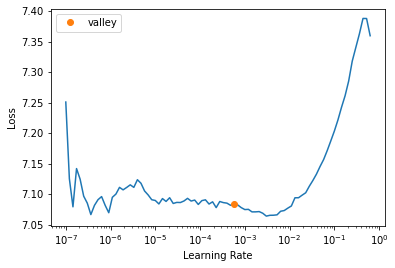

In [61]:
learn.lr_find()

In [62]:
learn.unfreeze()

In [ ]:
# learn.fit_flat_cos(200, 1e-2, wd=1e-2)
learn.fit_one_cycle(600, 1e-3, wd=1e-6, moms=(0.95, 0.85, 0.95))

Better model found at epoch 0 with valid_loss value: 7.121142864227295.
Better model found at epoch 12 with valid_loss value: 7.101155757904053.
Better model found at epoch 25 with valid_loss value: 7.088881492614746.
Better model found at epoch 37 with valid_loss value: 7.079385757446289.
Better model found at epoch 53 with valid_loss value: 7.076108932495117.
Better model found at epoch 59 with valid_loss value: 7.067768096923828.
Better model found at epoch 60 with valid_loss value: 7.067691326141357.
Better model found at epoch 62 with valid_loss value: 7.063866138458252.
Better model found at epoch 73 with valid_loss value: 7.055429458618164.
Better model found at epoch 75 with valid_loss value: 7.044403553009033.
Better model found at epoch 78 with valid_loss value: 7.0031867027282715.
Better model found at epoch 93 with valid_loss value: 6.9627604484558105.
Better model found at epoch 114 with valid_loss value: 6.958188533782959.
Better model found at epoch 116 with valid_loss v

In [65]:
run_name = wandb.run.name
if WANDB: wandb.finish()

In [66]:
save_name = f'run-{run_name}-swav-{arch}-pretrain-rice-disease-epc{197}-sz{size}px-bs{bs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.load(f"best")

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(200, 0.0001, wd=0.0001, moms=(0.99, 0.99, 0.99))

In [ ]:
learn.load("swav-best-xresnet34-bs32-size-128px")

In [ ]:
learn.encoder.state_dict().keys()

### Downstream Task

In [ ]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs,size=32,224

In [ ]:
label_block = MultiCategoryBlock(vocab="blast, brown, healthy", add_na=True)
clas_block = DataBlock(blocks=(ImageBlock, label_block),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=image_path),
                       get_y=ColReader(1),
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms(flip_vert=True))

In [ ]:
train_dl = clas_block.dataloaders(train_df)

In [ ]:
train_dl.show_batch()

In [ ]:
train_items = [(f, []) for f in files if f.name in list(train_df.Image_id.values)]
valid_items = [f for f in files if f.name in list(test_df.Image_id.values)]

In [ ]:
sample_df = pd.read_csv(path/"SampleSubmission.csv")

In [ ]:
sample_df.head()